# Tensorflow Probability & Treeflow Demo
Author: Christiaan Swanepoel

In [17]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt

## Tensorflow Probability distributions
Represents distributions on `tf.Tensor` (or nested structures of tensors)

### Properties
* `dtype`
* `reparameterization_type`

### Core methods
* `log_prob`
* `sample`

### Shape

* **Event shape** - shape of a single draw (may or may not be dependent across dimensions)
* **Batch shape** - independent samples from a collection of distributions (may or may not be i.i.d.)
* **Sample shape** - i.i.d draws - specific to `log_prob` / `sample` call

In [18]:
mus = np.random.normal(size=(3, 2))
norm = tfd.Normal(mus, 1.0)
dirichlet = tfd.Dirichlet(np.exp(mus))
dists = norm, tfd.Sample(norm, sample_shape=4), tfd.Independent(norm, reinterpreted_batch_ndims=1), dirichlet
dists

(<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float64>,
 <tfp.distributions.Sample 'SampleNormal' batch_shape=[3, 2] event_shape=[4] dtype=float64>,
 <tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float64>,
 <tfp.distributions.Dirichlet 'Dirichlet' batch_shape=[3] event_shape=[2] dtype=float64>)

In [19]:
[dist.sample().shape for dist in dists]

[TensorShape([3, 2]),
 TensorShape([3, 2, 4]),
 TensorShape([3, 2]),
 TensorShape([3, 2])]

## Automatic differentiation

In [20]:
mu = tf.convert_to_tensor(2.0)

with tf.GradientTape() as t:
    t.watch(mu)
    dist = tfd.Normal(mu, 1.0)
    logp = dist.log_prob(1.2)
    
logp, t.gradient(logp, mu)

(<tf.Tensor: shape=(), dtype=float32, numpy=-1.2389385>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.79999995>)

### Reparameterization trick

In [21]:
with tf.GradientTape() as t:
    t.watch(mu)
    dist = tfd.Normal(mu, 1.0)
    samples = dist.sample(2)
    res = tfp.monte_carlo.expectation(lambda x: x ** 2.0, samples, log_prob=dist.log_prob)
    
res, t.gradient(res, mu)

(<tf.Tensor: shape=(), dtype=float32, numpy=8.150196>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.8955603>)

## Distributions on trees
* Distribution on (nested) dictionary of tensors
  * Topology
  * Heights
    * Leaf heights included in "data" - not clear what the right decision is
* [`treeflow.tree`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree.py) - Base class `TreeDistribution`
* [`treeflow.coalescent`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/coalescent.py)
* [`treeflow.birthdeath`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/birthdeath.py)
* (sampling not yet implemented)

In [22]:
from treeflow.coalescent import ConstantCoalescent

coalescent = ConstantCoalescent(3, 10.0, np.zeros(3))
# Some problem with shape functions - using sample to show shape
coalescent.sample()

/mnt/c/chris/git/treeflow/treeflow/coalescent.py:70: UserWarning: Dummy sampling
  warnings.warn('Dummy sampling')


{'heights': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>,
 'topology': {'parent_indices': <tf.Tensor: shape=(4,), dtype=int32, numpy=array([0, 0, 0, 0], dtype=int32)>}}

In [23]:
parent_indices = [3, 3, 4, 4]

coalescent.log_prob({
    'heights': tf.convert_to_tensor([[0, 0, 0, 1.0, 2.0], [0, 0, 0, 0.8, 2.2]]),
    'topology': { 'parent_indices': tf.convert_to_tensor([parent_indices, parent_indices])  }
})

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.0051703, -4.9851704], dtype=float32)>

## Tensorflow Probability bijectors
Transformations of distributions
* Works with `TransformedDistribution`
* Simple transformations like `Exp`, `Sigmoid`
* Trainable transformations like `MaskedAutoregressiveFlow`
* Compositions like `Chain`, `Blockwise`
### Core methods
* `forward`
* `inverse`
* `log_det_jacobian` (of inverse)

In [24]:
log_normal = tfd.TransformedDistribution(norm, tfp.bijectors.Exp())
log_normal.sample()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[1.45145381, 2.23026941],
       [0.11088127, 0.34218601],
       [0.14327447, 0.06573599]])>

## Bijectors for trees
* [`treeflow.tree_transform`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree_transform.py)
  * Note: indexing conventions are not very standardised
* Distributions on node heights constructed in  [`treeflow.model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/model.py)

In [25]:
from treeflow.tree_transform import BranchBreaking

base_dist = tfd.Independent(tfd.Normal(tf.zeros(2), 1.0), reinterpreted_batch_ndims=1)

ratio_dist = tfd.TransformedDistribution(base_dist, tfp.bijectors.Sigmoid())

preorder_node_indices = [0]
tree_bij = BranchBreaking(tf.convert_to_tensor(parent_indices[3:]) - 3, tf.convert_to_tensor(preorder_node_indices))
height_dist = tfd.TransformedDistribution(ratio_dist, tree_bij)

height_dist.sample()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.13923661, 0.47366536], dtype=float32)>

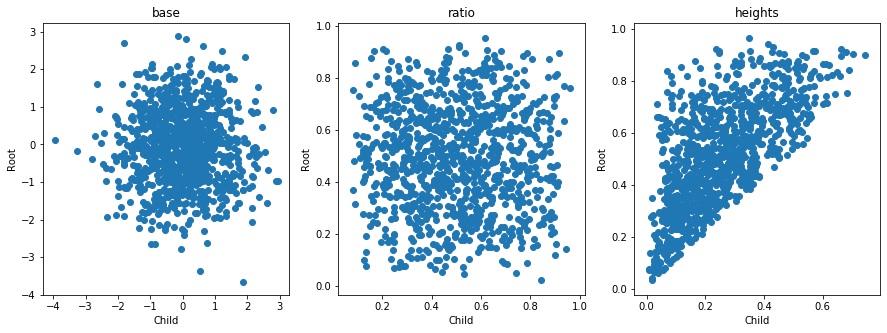

In [26]:
dists = {
    'base': base_dist,
    'ratio': ratio_dist,
    'heights': height_dist
}

fig, axs = plt.subplots(ncols=len(dists), figsize=(15, 5))
for (name, dist), ax in zip(dists.items(), axs):
    samples = dist.sample(1000)
    ax.scatter(samples[:, 0], samples[:, 1])
    ax.set_title(name)
    ax.set_xlabel('Child')
    ax.set_ylabel('Root')

## Tensorflow Probability Joint distributions
Build structured distributions by composing other distributions
### Phylogenetic prior
* [`treeflow.tree_processing`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tree_processing.py) - Building Tensor representations of trees

In [27]:
import treeflow.tree_processing

newick_file = 'demo-data/dengue.newick'

tree, taxon_names = treeflow.tree_processing.parse_newick(newick_file)
topology = treeflow.tree_processing.update_topology_dict(tree['topology'])
taxon_count = len(taxon_names)
sampling_times = tf.convert_to_tensor(tree['heights'][:taxon_count], dtype=tf.float32)

prior = tfd.JointDistributionNamed(dict(
    clock_rate=tfd.LogNormal(loc=0.0, scale=3.0),
    pop_size=tfd.LogNormal(0.0, 3.0),
    tree=lambda pop_size: ConstantCoalescent(taxon_count, pop_size, sampling_times)
))
prior.sample()

{'pop_size': <tf.Tensor: shape=(), dtype=float32, numpy=0.65943694>,
 'tree': {'heights': <tf.Tensor: shape=(33,), dtype=float32, numpy=
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32)>,
  'topology': {'parent_indices': <tf.Tensor: shape=(32,), dtype=int32, numpy=
   array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>}},
 'clock_rate': <tf.Tensor: shape=(), dtype=float32, numpy=0.15002687>}

## Approximate phylogenetic posteriors

* [`treeflow.model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/model.py) - automatic construction of variational approximations

In [28]:
import treeflow.model

rate_mean = 1e-3

q_prior = treeflow.model.construct_prior_approximation(prior)
q_tree = treeflow.model.construct_tree_approximation(newick_file)
q = tfd.JointDistributionNamed(dict(tree=q_tree, **q_prior))
q.sample()

{'tree': {'topology': {'parent_indices': <tf.Tensor: shape=(32,), dtype=int64, numpy=
   array([17, 17, 18, 19, 19, 20, 22, 23, 23, 24, 25, 26, 27, 28, 29, 30, 31,
          18, 21, 20, 21, 22, 32, 24, 25, 26, 27, 28, 29, 30, 31, 32])>},
  'heights': <tf.Tensor: shape=(33,), dtype=float32, numpy=
  array([10.00009 , 16.00008 , 16.00009 , 30.00009 , 10.00011 , 38.0001  ,
         31.00009 , 12.00005 , 11.00005 , 13.00006 , 10.00005 ,  8.00005 ,
          0.      , 15.00005 ,  9.00005 , 17.00005 , 18.00005 , 29.398186,
         41.683304, 31.355835, 39.805023, 50.08493 , 64.13157 , 12.931733,
         13.122627, 13.957667, 16.158218, 16.263655, 17.748783, 17.809546,
         19.792215, 20.237719, 65.6428  ], dtype=float32)>},
 'pop_size': <tf.Tensor: shape=(), dtype=float32, numpy=0.12863068>,
 'clock_rate': <tf.Tensor: shape=(), dtype=float32, numpy=1.3809838>}

In [29]:
q.trainable_variables

(<tf.Variable 'q_tree_loc:0' shape=(16,) dtype=float32, numpy=
 array([-0.787627  ,  0.06899995, -0.33211875, -0.91774   ,  0.6150109 ,
         4.448606  ,  0.8150513 , -0.56784046,  0.36707997,  3.4415805 ,
         0.82001513,  1.8319874 , -0.4479922 ,  2.5579515 , -2.404662  ,
         3.7897913 ], dtype=float32)>,
 <tf.Variable 'q_tree_scale:0' shape=(16,) dtype=float32, numpy=
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32)>,
 <tf.Variable 'q_pop_size_loc:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'q_pop_size_scale:0' shape=() dtype=float32, numpy=0.54132485>,
 <tf.Variable 'q_clock_rate_loc:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'q_clock_rate_scale:0' shape=() dtype=float32, numpy=0.54132485>)

## Phylogenetic likelihoods with Beagle
* [`treeflow.beagle`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/beagle.py) - Phylogenetic likelihood calculation with Beagle using `libsbn`
* [`treeflow.substitution_model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/substitution_model.py) - Includes differential matrices for calculating substitution model parameter gradients
* [`treeflow.sequences`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/sequences.py) - Tensor representations of alignments, plugging likelihoods into the Tensorflow graph

Substitution model parameter gradients not yet implemented so they're fixed for now (values from maximum likelihood).

In [30]:
import treeflow.beagle
import treeflow.substitution_model
import treeflow.sequences

subst_model = treeflow.substitution_model.HKY()
likelihood, instance = treeflow.beagle.log_prob_conditioned_branch_only(
    newick_file,
    'demo-data/dengue.fasta',
    subst_model,
    np.array([0.293402, 0.20491, 0.256425, 0.245264]),
    kappa=20.065921,
    rescaling=True)

wrapped_likelihood = lambda z: likelihood(treeflow.sequences.get_branch_lengths(z['tree']) * tf.expand_dims(z['clock_rate'], -1))
wrapped_likelihood(q.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-27471.336>

## Variational inference

In [31]:
log_posterior = lambda **z: (prior.log_prob(z) + wrapped_likelihood(z))
log_posterior(**q.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-28542.416>

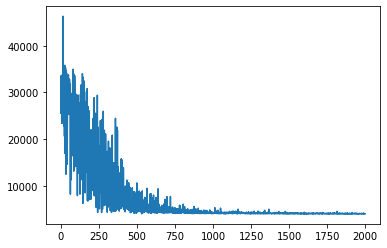

In [32]:
loss = tfp.vi.fit_surrogate_posterior(log_posterior, q, tf.optimizers.Adam(learning_rate=0.01), 2000)
plt.plot(loss)

## Other bits of Treeflow
* [`treeflow.tensorflow_likelihood`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/tensorflow_likelihood.py) - Phylogenetic likelihood calculation with [Xiang et al. 2020 method](https://academic.oup.com/mbe/advance-article-abstract/doi/10.1093/molbev/msaa130/5847600)
* [`treeflow.site_model`](https://github.com/christiaanjs/treeflow/blob/master/treeflow/site_model.py) - Works with Tensorflow likelihood implementation

## Things to do
[Github issues](https://github.com/christiaanjs/treeflow/issues)